# Imports

In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

# Quadratic functions

$$f(x) = \frac{1}{2}(x, Q x) + (b, x)$$
$$\nabla f(x) = Qx + b$$

$$x^* = - Q^{-1} b$$

In [14]:
class Descent:

    def __init__(self):
        self._step = 0
        self.max_iter = 2000
        self.delta = 1e-9

    def project_func(self, point):
        return point
    
    def calculate_lambda(self, point, gradient, Weight_matrix) -> int:
        val = gradient(point)
        abs_val = np.absolute(val)
        numerator = abs_val.dot(abs_val)
        denumerator = val.T.dot(2*Weight_matrix).dot(val)
        return numerator / denumerator


    def __call__(self, start_point, func, gradient, Weight_matrix, x_star):
        current_point = start_point
        alfa = 0.1
        x_array = []
        f_k = []
        current_func_val = func(current_point)
        best_func_val = func(x_star)
        while current_func_val-best_func_val > self.delta and np.linalg.norm(current_point-x_star) > self.delta and self._step < self.max_iter:
            self._step += 1
            x_array.append(current_point)
            f_k.append(current_func_val)
            
            p = self.find_p(gradient, current_point)
            lamd = self.calculate_lambda(current_point, gradient, Weight_matrix)
            second_counter = 0
            while second_counter < 10:
                second_counter +=1
                x_k_1_point = self.project_func(current_point + lamd * p)

                f_k_1_val = func(x_k_1_point)
                grad_val_np = gradient(current_point)

                if f_k_1_val <= current_func_val + alfa * lamd * np.dot(grad_val_np, p):
                    current_point = x_k_1_point
                    current_func_val = f_k_1_val
                    break
                else:
                    lamd = lamd / 2.0
            
                
        return {'x_k' : x_array, 'f_k' : f_k}


class CoodinateDescent(Descent):
    
    def __init__(self):
        super().__init__()
        self.last_axis_index = 0

    def find_p(self, gradient, current_point):
        #Search of direction
        value_of_grad = gradient(current_point)
        new_direction = (self.last_axis_index + 1) % len(value_of_grad)
        self.last_axis_index = new_direction
        #Calculate P
        val = value_of_grad[new_direction]
        sign = - val/abs(val)
        e = np.zeros((len(value_of_grad)))
        e[new_direction] = 1
        e = e * sign
        return e


class GradientDescent(Descent):

     def find_p(self, gradient, point):
        return -gradient(point)

    
class GradientDescentProject(GradientDescent):

    def __init__(self, project_func):
        super().__init__()
        self.project_func = project_func

    def calculate_lambda(self, point, gradient, Weight_matrix) -> int:
        return 1 / (1 + self._step)

In [3]:
def quad(Q, b, x):
    """
    Возвращает число
    """
    return ( 0.5 * Q.dot(x) + b).dot(x)
def quad_grad(Q, b, x):
    """
    Возвращает матрицу размером Mx1
    """
    return Q.dot(x) + b

def quad_2d_XY(Q, b, X, Y):
    Z = np.zeros(shape = X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = quad(Q, b, (X[i,j], Y[i,j]))
    return Z

# Some function,
# accepts, initial point (a numpy vector), function, its derivative, and (optionally) parameters
# return sequence of points
def const_step_solver(x0, f, f_grad, params = None):
    x = x0.copy()
    x_array = [x]
    f_array = [ f(x) ]
    gamma = 0.5
    # stopping rule
    k = 0
    while k < 100:
        x = x + gamma * (-f_grad(x))
        x_array += [ x ]
        f_array += [ f(x) ]
        #print(f(x))
        k += 1
    print('{} iterations is taken, f(x^k) = {}'.format(k, f_array[-1]))
    return {'x_k' : x_array, 'f_k' : f_array}

In [4]:
def init():
    np.random.seed(42)
    n = 5
    m = 2
    A = np.random.rand(n, m)
    b = 4 * np.random.rand(m)
    Q = A.T.dot(A)
    eigs = np.linalg.eigvals(Q)
    L = max(eigs)
    mu = min(eigs)
    print('mu = {}, L = {}'.format(mu, L))

    # plot contours
    X, Y = np.meshgrid(np.linspace(-5, 15, 400), np.linspace(-10, 3, 100))
    Z_quad = quad_2d_XY(Q, b, X, Y)
    x_star = -np.linalg.inv(Q).dot(b)
    x_0 = x_star - [8, 0]
    print(x_star)
    gamma = 0.6
    levels = quad(Q, b, x_star) + np.linspace(0, 10, 6)**2
    return Q, b, X, Y, Z_quad, x_star, x_0, gamma, levels

In [5]:
def optimize(my_opt_func):
    Q, b, X, Y, Z_quad, x_star, x_0, gamma, levels = init()
    _, axes = plt.subplots(1,2,figsize=(15, 5))
    for k in (0, 1):
        axes[k].axis('equal')
        axes[k].plot(x_star[0], x_star[1], '*')
        axes[k].plot(x_0[0], x_0[1], 'or')
        axes[k].plot((x_0[0], (x_0 - gamma*quad_grad(Q, b, x_0))[0]), 
                     (x_0[1], (x_0 - gamma*quad_grad(Q, b, x_0))[1]), 'r')
        axes[k].contour(X, Y, Z_quad, levels)

    # run solver for two different initial conditions
    alg_data = my_opt_func(x_0, lambda x : quad(Q, b, x), lambda x : quad_grad(Q, b, x), Q, x_star)
    x_data = np.array(alg_data['x_k'])
    axes[1].plot(x_data[:, 0], x_data[:, 1],) 
    #print(x_data)
    print(quad(Q, b, x_star))
    # plt.show() - not needed if %matplotlib magic is used

    _, axes = plt.subplots(2,2,figsize=(15, 5))
    f_k_residual = alg_data['f_k'] - quad(Q, b, x_star)
    N = len(f_k_residual)
    x_k_residual = x_data - np.kron(np.ones( (N, 1) ), x_star)
    axes[0][0].set_title('Function residual')
    axes[0][0].plot(f_k_residual, ) 
    axes[0][1].set_title('Logarithmic function residual')
    axes[0][1].plot(np.log(f_k_residual), ) 

    a, b = -0.1, 2
    # axes[0][1].plot(np.arange(N), np.arange(N)*a + b) # some line
    axes[1][0].set_title('Value residual (Euclidean norm)')
    axes[1][0].plot(np.arange(N), np.linalg.norm(x_k_residual, axis=1))
    axes[1][1].set_title('Logarithmic value residual (Euclidean norm)')
    axes[1][1].plot(np.arange(N), np.log(np.linalg.norm(x_k_residual, axis=1)) )
    # axes[1][1].plot(np.arange(N), np.arange(N)*a + b) # another line

# The constrained optimization problems

mu = 0.31224936468495423, L = 3.291112700725653
[ 4.68399741 -3.91749557]


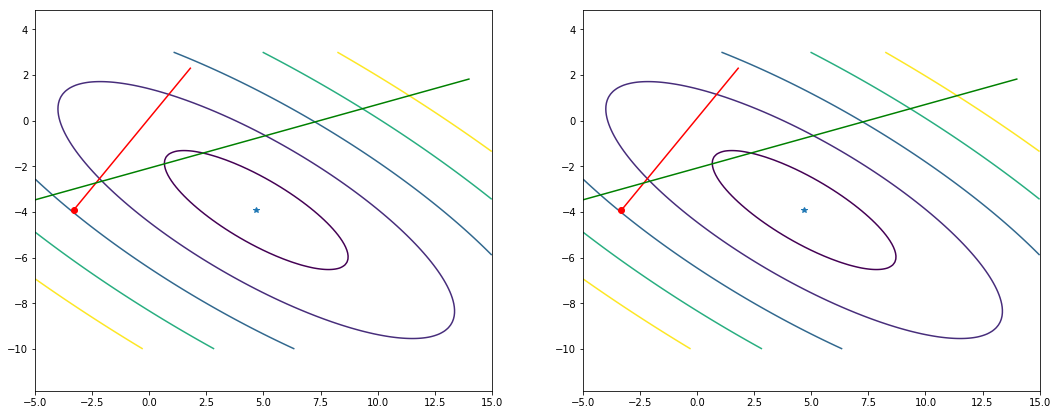

In [29]:
n = 5
m = 2
A = np.random.rand(n, m)
b = 4 * np.random.rand(m)
Q = A.T.dot(A)
eigs = np.linalg.eigvals(Q)
L = max(eigs)
mu = min(eigs)
print('mu = {}, L = {}'.format(mu, L))

# plot contours
X, Y = np.meshgrid(np.linspace(-5, 15, 400), np.linspace(-10, 3, 100))
Z_quad = quad_2d_XY(Q, b, X, Y)
x_star = -np.linalg.inv(Q).dot(b)
x_0 = x_star - [8, 0]
print(x_star)
gamma = 0.6

# line
np.random.seed(42)
a = np.random.randn(2)
a = a / np.linalg.norm(a)
d = -2
line_x1 = np.array([-5, 14])
line_x2 = (d - a[1]*line_x1) / a[0]

_, axes = plt.subplots(1,2,figsize=(18, 7))
for k in (0, 1):
    axes[k].plot(x_star[0], x_star[1], '*')
    axes[k].plot(x_0[0], x_0[1], 'or')
    axes[k].plot((x_0[0], (x_0 - gamma*quad_grad(Q, b, x_0))[0]), 
                 (x_0[1], (x_0 - gamma*quad_grad(Q, b, x_0))[1]), 'r')
    axes[k].plot(line_x1, line_x2, 'g')
    axes[k].contour(X, Y, Z_quad, levels)
    axes[k].axis('equal')


In [19]:
alpha.shape

(100,)

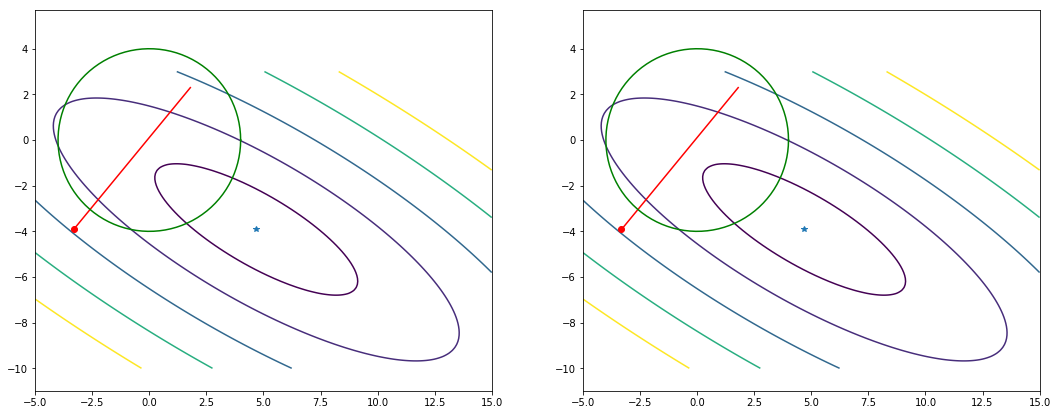

In [18]:
# circle
alpha = np.linspace(0, 2*np.pi, 100)
r = 4
circle_x1 = r*np.cos(alpha)
circle_x2 = r*np.sin(alpha)

_, axes = plt.subplots(1,2,figsize=(18, 7))
for k in (0, 1):
    axes[k].plot(x_star[0], x_star[1], '*')
    axes[k].plot(x_0[0], x_0[1], 'or')
    axes[k].plot((x_0[0], (x_0 - gamma*quad_grad(Q, b, x_0))[0]), 
                 (x_0[1], (x_0 - gamma*quad_grad(Q, b, x_0))[1]), 'r')
    axes[k].plot(circle_x1, circle_x2, 'g')
    axes[k].contour(X, Y, Z_quad, levels)
    axes[k].axis('equal')



# Task 1. Gradient descent

mu = 0.31224936468495423, L = 3.291112700725653
[ 4.68399741 -3.91749557]
-7.406399665468871


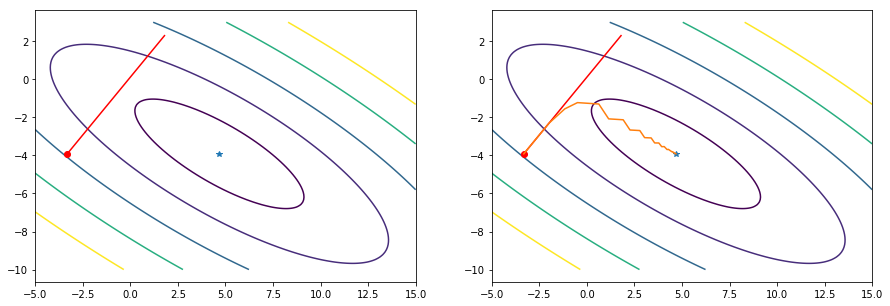

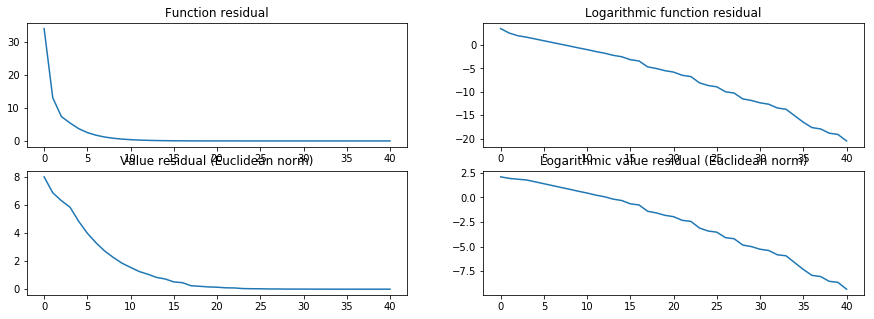

In [15]:
optimize(GradientDescent())

# Task 2. Coordinate descent

mu = 0.31224936468495423, L = 3.291112700725653
[ 4.68399741 -3.91749557]
-7.406399665468871


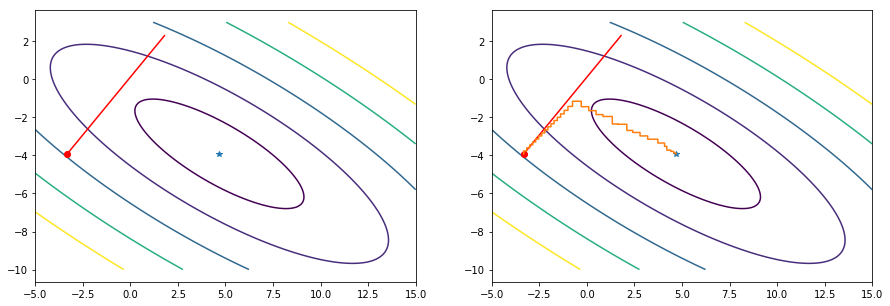

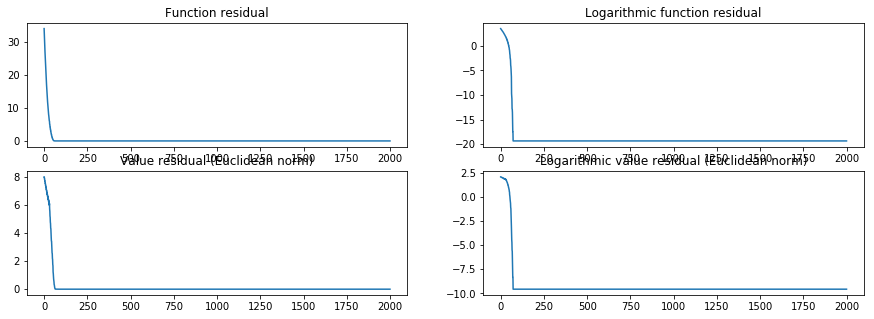

In [16]:
optimize(CoodinateDescent())

# Task 3. Line constraint

In [17]:
class LineProjection:
    
    X_POS = 0
    Y_POS = 1

    def __init__(self, point_1, point_2):
        self.__A = point_2[LineProjection.Y_POS] - point_1[LineProjection.Y_POS]
        self.__B = -(point_2[LineProjection.X_POS] - point_1[LineProjection.X_POS])
        self.__C = point_1[LineProjection.X_POS] * self.__A + point_1[LineProjection.Y_POS] * self.__B
        

    def __call__(self, point):
        C = self.__A * point[LineProjection.Y_POS] - self.__B * point[LineProjection.X_POS]
        y = ((self.__C * self.__B) / self.__A - C) / (self.__A - (self.__B * self.__B / self.__A))
        x = (-self.__C - self.__B * y) / self.__A
        return x, y

mu = 0.31224936468495423, L = 3.291112700725653
[ 4.68399741 -3.91749557]
Run solver


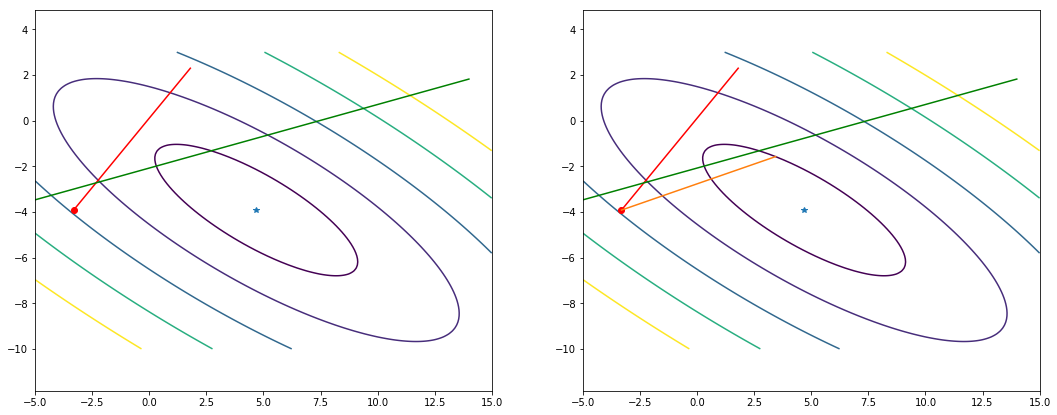

In [18]:
Q, b, X, Y, Z_quad, x_star, x_0, gamma, levels = init()
# line
np.random.seed(42)
a = np.random.randn(2)
a = a / np.linalg.norm(a)
d = -2
line_x1 = np.array([-5, 14])
line_x2 = (d - a[1]*line_x1) / a[0]

_, axes = plt.subplots(1,2,figsize=(18, 7))
for k in (0, 1):
    axes[k].plot(x_star[0], x_star[1], '*')
    axes[k].plot(x_0[0], x_0[1], 'or')
    axes[k].plot((x_0[0], (x_0 - gamma*quad_grad(Q, b, x_0))[0]), 
                 (x_0[1], (x_0 - gamma*quad_grad(Q, b, x_0))[1]), 'r')
    axes[k].plot(line_x1, line_x2, 'g')
    axes[k].contour(X, Y, Z_quad, levels)
    axes[k].axis('equal')

project = LineProjection(line_x1, line_x2)
descent = GradientDescentProject(project)
# run solver for two different initial conditions
print("Run solver")
alg_data = descent(x_0, lambda x : quad(Q, b, x), lambda x : quad_grad(Q, b, x), Q, x_star)
x_data = np.array(alg_data['x_k'])
axes[1].plot(x_data[:, 0], x_data[:, 1],) 


# Task 4. 2D-ball constraint

In [19]:
class CircleProjection:
    
    X_POS = 0
    Y_POS = 1

    def __init__(self, radius):
        self._radius = radius
        self._sq_radius = radius * radius
        

    def __call__(self, point):
        x = point[CircleProjection.X_POS]
        y = point[CircleProjection.Y_POS]
        if x*x + y*y <= self._sq_radius:
            result = point
        else:
            destination = math.sqrt(x*x + y*y)
            sin_fi = y / destination
            cos_fi = math.sqrt(1 - sin_fi * sin_fi)
            result = (self._radius * cos_fi, self._radius * sin_fi)
        return result

mu = 0.31224936468495423, L = 3.291112700725653
[ 4.68399741 -3.91749557]
Run solver


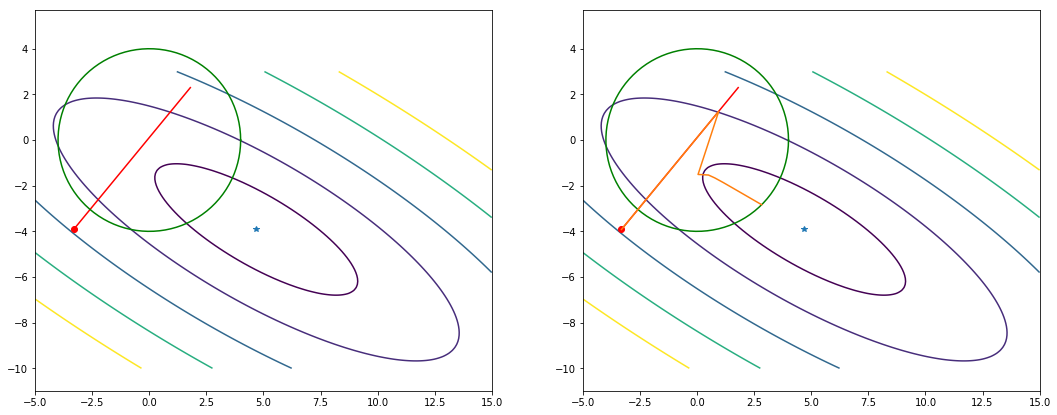

In [20]:
Q, b, X, Y, Z_quad, x_star, x_0, gamma, levels = init()

# circle
alpha = np.linspace(0, 2*np.pi, 100)
r = 4
circle_x1 = r*np.cos(alpha)
circle_x2 = r*np.sin(alpha)

_, axes = plt.subplots(1,2,figsize=(18, 7))
for k in (0, 1):
    axes[k].plot(x_star[0], x_star[1], '*')
    axes[k].plot(x_0[0], x_0[1], 'or')
    axes[k].plot((x_0[0], (x_0 - gamma*quad_grad(Q, b, x_0))[0]), 
                 (x_0[1], (x_0 - gamma*quad_grad(Q, b, x_0))[1]), 'r')
    axes[k].plot(circle_x1, circle_x2, 'g')
    axes[k].contour(X, Y, Z_quad, levels)
    axes[k].axis('equal')
    
project = CircleProjection(r)
descent = GradientDescentProject(project)
# run solver for two different initial conditions
print("Run solver")
alg_data = descent(x_0, lambda x : quad(Q, b, x), lambda x : quad_grad(Q, b, x), Q, x_star)
x_data = np.array(alg_data['x_k'])
axes[1].plot(x_data[:, 0], x_data[:, 1],) 